# PROJECT 2 - DEEP LEARNING

## THE MNIST DATADASE

Uma rede neural treinada para reconhecer imagens e problemas númericos escritos à mão.  

- Pode ser usado para interpretar um CEP de uma carta escrita manualmente
automaticamente.

In [1]:
import numpy as np
import torch
import torch.nn.functional as nf
#library for computation vision
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
import matplotlib
import matplotlib.pyplot as plt
from time import time

## Transform dataset(images) for Tensor file


In [2]:
#Copied MNIST database on site them
transform = transforms.ToTensor()

#Carrega a parte de treino do dataset
trainset = datasets.MNIST('./MNIST_data/', 
                          download = True,
                          train = True,
                          transform = transform
                          )

#Cria um buffer para coletar os dados por partes
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = 64,
                                          shuffle = True
                                          )

#Carrega os pacotes de validação do dataset
valida_set = datasets.MNIST('./MNIST_data',
                        download = True,
                        train = False,
                        transform = transform
                        )

#Cria um buffer para pegar os dados por partes
valida_loader = torch.utils.data.DataLoader(valida_set,
                                            batch_size = 64,
                                            shuffle = True
                                            )


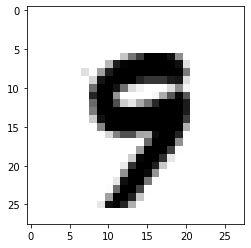

In [3]:
#Conferir a estrutura de dados representa a imagem corretamente
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.next()
plt.imshow(imagens[0].numpy().squeeze(),
           cmap = 'gray_r');

In [4]:
#Conferir o tamanho da imagem e etiqueta (dimensões do Tensor)
print(imagens[0].shape)
print(etiquetas[0].shape)

torch.Size([1, 28, 28])
torch.Size([])


## KERAS
Keras é uma API projetada para seres humanos, não para máquinas. O Keras segue as melhores práticas para reduzir a carga cognitiva: oferece APIs simples e consistentes, minimiza o número de ações do usuário necessárias para casos de uso comuns e fornece mensagens de erro claras e acionáveis. Ele também possui extensa documentação e guias para desenvolvedores.

In [5]:
# Neural network - 
# Keras - inceptionv3 (herança: copiando as camadas da rede)
class Modelo(nn.Module):
    def __init__(self):
        """
        Camadas de entrada e interna
        - Usando uma função linear que ativa as camadas internas da rede.
        --------
        Possibilidade de alterar a quantidade de neurônios,
        porém quando maior a quantidade mais processamento é exigido.
        """
        super(Modelo, self).__init__()
        #Comada de entrada, 784 neurônios que se ligam a 128.
        self.linear1 = nn.Linear(28*28, 128)
        #Camada interna 1: 128 neurônios -> 64 neurônios.
        self.linear2 = nn.Linear(128, 64)
        #Camada interna 2: 64 neurônios -> 10 neurônios.
        self.linear3 = nn.Linear(64, 10)
        #Não ha necessidade de definir uma camada de saída, porque 
        #usamos o output da camada interna 2.
        
    def forward(self, x):
        """Funções de ativação das camadas e retornando a perda atráves da função softmax."""
        x = F.relu(self.linear1(x))     #Camada de entrada => interna 1
        x = F.relu(self.linear2(x))     #Interna 1 => interna 2
        x = self.linear3(x)             #Interna 2 => saída (f(x) = x)
        return F.log_softmax(x, dim=1)  #Dados utilizados para calcular a perda 
    

## TREINAMENTO / OTIMIZAÇÃO

- Estrutura de treinamento da rede
- Número de épocas do treinamento é 10.

## Parâmetros de Bias
A tradução de bias para o português é viés. 
Os significados mais relevantes para um contexto de dados são o de tendência e distorção.

**Na estatística:** É o de desvio sistemático do valor real. É desvio por não coincidir com o valor real e é sistemático por acontecer consistentemente, em média.

**Em Ciências de Dados:** O viés também é chamado de erro sistemático, pois ele é sobre o algoritmo não ser capaz de expressar a forma funcional com que aquele fenômeno se dá. Ou seja, por mais que usemos amostras diferentes ou maiores, ele nunca se aproximará do valor real que queremos estimar, pois não é capaz.

**Referência:** [Bias em Ciência de Dados - Luis Moneda](http://lgmoneda.github.io/2019/01/14/bias-data-science.html)

In [6]:
def treino(modelo, trainloader, device):
    """Estrutura de treinamento da rede neural."""
    #-------------------------------------------------------------------
    #Parâmetros de Bias
    #Define a política de atualização dos pesos e da blas
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentun=0.5)
    #Timer para duração do treino
    inicio = time()
    #-------------------------------------------------------------------
    #Definindo o critério para calcular a perda
    criterio = nn.NLLLoss()
    #Número de épocas que o algoritmo rodará
    #Ideal > 100 épocas
    EPOCHS = 10
    #Ativação do modo de treinamento do modelo
    modelo.train()
    #-------------------------------------------------------------------
    
    for epoch in range(EPOCHS):
        #Iniciação da perda acumulada
        perda_acumulada = 0
        
        for imagens, etiquetas in trainloader:
            #-----------------------------------------------------------
            #Convertendo imagens para vetores
            imagens = imagens.view(imagens.shape[0], -1)
            #Zerando os gradientes por conta do ciclo anterior
            otimizador = zero_grad()
            #-----------------------------------------------------------
            #Colocando os dados no modelo
            output = modelo(imagens.to(device))
            #Calculando a perda da época em questão
            perda_instantanea = criterio(output, etiquetas.to(device))
            #-----------------------------------------------------------
            #Back propagation a partir da perda
            perda_instantanea.backward()
            #-----------------------------------------------------------
            #Atualizando os pesos e a bias
            otimizador.step()
            #-----------------------------------------------------------
            #Atualização da perda acumulada
            perda_acumulada += perda_instantanea.item()
            #-----------------------------------------------------------
            
        else:
            print(f'Epoch: {epoch+1}')
            print(f' Perda resultante: {perda_acumulada/len(trainloader)}')
    
    print('------------')
    print(f'Tempo do treinamento: {(time() - inicio/60)}')

## VALIDAÇÃO DO CÓDIGO
- Calculando o valor de accuracy
- Modelo implementado pelo Keras

In [7]:
def validacao(modelo, valida_loader, device):
    """Verificação da base de dados do treino em relação ao treinamento."""
    conta_correta, conta_all = 0, 0
    
    for imagens, etiquetas in valida_loader:
        for i in range(len(etiquetas)):
            img = image[i].view(1, 784)
            #Desativação do autograd para acelerar a validação
            #Grafos computacionais dinâmicos possuem um alto custo de processamento
            with torch.no_grad():
                #Output do modelo em escala logarítmica
                logp = modelo(img.to(device))
            #----------------------------------------------------------------
            #Conversão para escola "normal" = Tensor    
            ps = torch.exp(logp)
            probab = list(ps.cpu().numpy()[0])
            #Converte um tensor em um número que o modelo previu como correto
            etiquetas_pred = probab.index(max(probab))
            etiquetas_certa = etiquetas.numpy()[1]
            #---------------------------------------------------------------
            #Comparando a previsão com o valor correto
            if (etiquetas_certa == etiquetas_pred):
                conta_correta +=1
            conta_all += 1
            #---------------------------------------------------------------
        
        
        print(f'Total de imagens testadas: {conta_all}')
        print(f'Precisão do modelo: {(conta_correta*100)/conta_all}')
        

## EXECUÇÃO DO MODELO

In [8]:
modelo = Modelo()
#Verificando se o CUDA está disponível na GPU
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)